In [20]:
#pip install pandas
#pip install openpyxl
#pip install scipy
#pip install matplotlib

In [21]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import gmean
from scipy import stats

In [22]:
pd.set_option('display.max_columns', 500)

In [23]:


# Sets the path to the parent directory of RR classes
os.chdir("c:\\Users\\Soumi\\RRcourse2024\\assign3\\RRcourse2024\\")


# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv("Data\\onet_tasks.csv")
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

#Coutries for which we need to run the program
country_list = ["Belgium", "Poland", "Spain"]

#Task variables list for which we need to calculate values
tasks_list = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.
try:
    task_data = pd.read_csv(Path("Data/onet_tasks.csv"))
except Exception as e:
    print(e)
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)
data_set_map = {}
try:
    data_set_map = {"isco1": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO1")),
    "isco2": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO2")),
    "isco3": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO3")),
    "isco4": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO4")),
    "isco5": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO5")),
    "isco6": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO6")),
    "isco7": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO7")),
    "isco8": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO8")),
    "isco9": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO9"))}
except Exception as e:
    print(e)

In [24]:
task_data.head(3)

,isco08,t_1A1f1,t_1A2a2,t_2B1a,t_4A2a4,t_4A2b2,t_4A3a3,t_4A3a4,t_4A4a1,t_4A4a4,t_4A4b4,t_4A4b5,t_4C2d1g,t_4C2d1i,t_4C3b4,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,1112,1.561667,1.373333,3.916667,3.898333,3.806667,1.970000,2.206667,3.931667,4.376667,4.258333,3.903333,2.175000,2.330000,3.846667,3.028333,1.370000,1.443333,1.193333,3.215000,2.353333,3.186667,4.023333,4.365000,4.381667
1,1113,1.185000,1.000000,4.000000,4.105000,4.180000,1.380000,1.420000,4.075000,4.390000,4.225000,3.780000,1.815000,2.270000,3.790000,2.735000,1.390000,1.330000,1.130000,3.795000,2.950000,3.630000,4.520000,4.835000,4.805000
2,1114,1.416667,1.510000,3.750000,3.848333,3.457500,2.370833,2.370000,3.677500,4.052500,3.820000,3.635000,2.319167,2.413333,4.079167,3.331667,1.488333,1.422500,1.225833,3.276667,2.597500,2.725833,3.767500,3.953333,4.114167


In [25]:
### Functions definitions ###
# function to calculate country specific total and shared value
def set_country_total_and_share(all_data, data_set_map, country_name):
    total_country = 0
    for k,v in data_set_map.items():
        # This will calculate worker totals in each of the chosen countries.
        total_country += v[country_name]
    # We have 9 occupations and the same time range for each, so we can add the totals by
    # adding a vector that is 9 times the previously calculated totals
    all_data["total_"+country_name] = pd.concat([total_country]*len(data_set_map), ignore_index=True)
    # And this will give us shares of each occupation among all workers in a period-country
    all_data["share_"+country_name] = all_data[country_name] / all_data["total_"+country_name]

# function to standardized variable
def standardized(data, weight):
    temp_mean = np.average(data, weights=weight)
    temp_sd = np.sqrt(np.average((data - temp_mean)**2, weights=weight))
    return (data - temp_mean) / temp_sd

In [26]:
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
for index, (key, value) in enumerate(data_set_map.items()):
    value['ISCO'] = index+1

# and this gives us one large file with employment in all occupations.
all_data = pd.concat(data_set_map.values(), ignore_index=True)

# set all required countries total and shared data
for country in country_list:
    set_country_total_and_share(all_data, data_set_map, country)

In [27]:
# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:

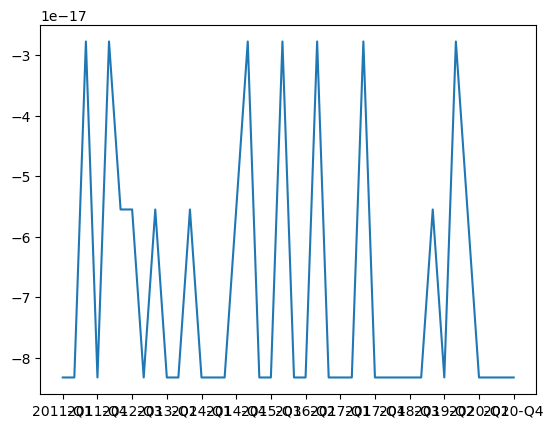

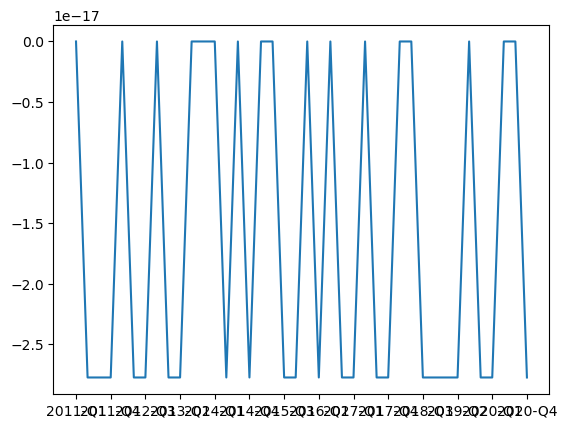

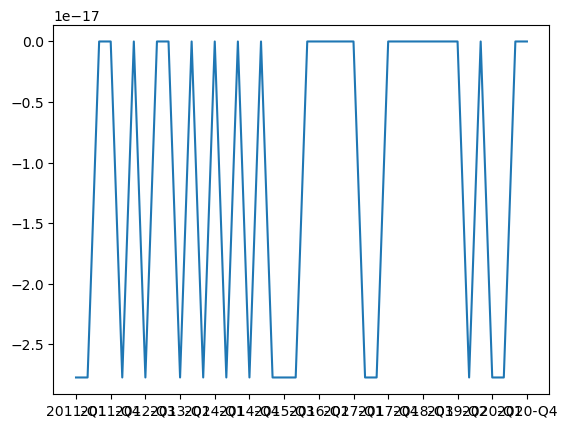

In [28]:
for country in country_list:
    task_content = 0
    for task in tasks_list:
        combined["std_"+country+"_"+task] = standardized(combined[task],combined["share_"+country])
        task_content += combined["std_"+country+"_"+task]
    # The next step is to calculate the `classic` task content intensity, i.e.
    # how important is a particular general task content category in the workforce
    # Here, we're looking at non-routine cognitive analytical tasks, as defined
    # by David Autor and Darron Acemoglu:
    combined[country+"_NRCA"] = task_content
    # And we standardise NRCA in a similar way.
    combined["std_"+country+"_NRCA"] = standardized(combined[country+"_NRCA"],combined["share_"+country])
    
    # Finally, to track the changes over time, we have to calculate a country-level mean
    # Step 1: multiply the value by the share of such workers.
    combined["multip_"+country+"_NRCA"] = combined["std_"+country+"_NRCA"] * combined["share_"+country]
    
    # Step 2: sum it up (it basically becomes another weighted mean)
    agg_Country = combined.groupby(["TIME"])["multip_"+country+"_NRCA"].sum().reset_index()

    # We can plot it now!
    plt.plot(agg_Country["TIME"], agg_Country["multip_"+country+"_NRCA"])
    plt.xticks(range(0, len(agg_Country), 3), agg_Country["TIME"][::3])
    plt.show()